Exploratory Data Analysis (EDA)
Крок 1:
Спочатку ми імпортуємо необхідні бібліотеки для обробки даних, візуалізації та статистичного тестування

In [1]:
# Сторонні бібліотеки
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sqlalchemy import create_engine
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import proportions_ztest

# Внутрішні модулі
from configs import PASSWORD

Крок 2:
Потім завантажуємо датасет A\B test pandas DataFrame для аналізу

In [2]:
# Шлях до файлу
file_path = r"E:\anaconda\envs\pydata-book\ab_test_dataset_v16.xlsx"

За допомогою функції **load_excel_sheets** переглядаємо назви всіх листів нашого датасету

In [3]:
def load_excel_sheets(file_path):
    xls = pd.ExcelFile(file_path)
    sheets = {}
    for name in xls.sheet_names:
        sheets[name] = pd.read_excel(xls, sheet_name=name)
    return sheets

all_sheets = load_excel_sheets(file_path)
all_sheets.keys()

dict_keys(['device', 'country', 'group', 'user', 'daily'])

 Збереження кожного листа в змінну

In [4]:
device_df = all_sheets["device"]
country_df = all_sheets["country"]
group_df = all_sheets["group"]
user_df = all_sheets["user"]
daily_df = all_sheets["daily"]

In [5]:
device_df.head()

,device_id,device_name
0,1,Desktop
1,2,Mobile
2,3,Smartwatch
3,4,TV
4,5,Tablet


In [6]:
country_df.head()

,country_id,country_code
0,1,BR
1,2,DE
2,3,FR
3,4,IN
4,5,US


In [7]:
group_df.head()

,group_id,group_label
0,1,A
1,2,B


In [8]:
user_df.head()

,user_id,device_id,country_id,group_id,days_on_product
0,7654,5.0,4.0,1.0,55.0
1,7866,2.0,1.0,2.0,39.0
2,3227,2.0,2.0,1.0,27.0
3,5913,2.0,3.0,1.0,61.0
4,8238,2.0,4.0,1.0,47.0


In [9]:
daily_df.head()

,user_id,date,converted
0,2518,2025-08-04,0.0
1,1157,2025-08-16,0.0
2,1240,2025-08-11,0.0
3,9009,2025-08-20,0.0
4,8494,2025-08-08,0.0


Крок 3:
Аналіз пропусків, кількості рядків та типів даних по листах датасету

In [10]:
data_summary = {}

# Проходимо по кожному листу
for sheet in all_sheets:
    df = pd.read_excel(file_path, sheet_name=sheet)

    missing = df.isnull().sum()
    num_records = len(df)
    dtypes = df.dtypes.astype(str)

    summary = pd.DataFrame({
        'Missing Count': missing,
        'record_counts': num_records,
        'Data Type': dtypes
    })
    data_summary[sheet] = summary

# Виводимо результати
for sheet, summary in data_summary.items():
    print(f"\n📄 Лист: {sheet}")
    print(summary)


📄 Лист: device
             Missing Count  record_counts Data Type
device_id                0              5     int64
device_name              0              5    object

📄 Лист: country
              Missing Count  record_counts Data Type
country_id                0              6     int64
country_code              0              6    object

📄 Лист: group
             Missing Count  record_counts Data Type
group_id                 0              2     int64
group_label              0              2    object

📄 Лист: user
                 Missing Count  record_counts Data Type
user_id                      0          10000     int64
device_id                  203          10000   float64
country_id                 669          10000   float64
group_id                    41          10000   float64
days_on_product            151          10000   float64

📄 Лист: daily
           Missing Count  record_counts       Data Type
user_id                0          61501           int64
date

Крок 4: Обробка та заміна пропущених даних та типів даних.

Оскільки найбільше пропущених даних у таблиці user, почнемо саме з неї

In [11]:
user_df.head()

,user_id,device_id,country_id,group_id,days_on_product
0,7654,5.0,4.0,1.0,55.0
1,7866,2.0,1.0,2.0,39.0
2,3227,2.0,2.0,1.0,27.0
3,5913,2.0,3.0,1.0,61.0
4,8238,2.0,4.0,1.0,47.0


In [12]:
user_df.columns

Index(['user_id', 'device_id', 'country_id', 'group_id', 'days_on_product'], dtype='object')

Ще раз подивимось на пропущені та аномальні значення в таблиці user

In [13]:
num_records_user = len(user_df)
missing_values_user = user_df.isnull().sum()

print(f'Загальна кількість записів: {num_records_user}')

print(f'Кількість пропущених записів:')
missing_values_user

Загальна кількість записів: 10000
Кількість пропущених записів:


user_id              0
device_id          203
country_id         669
group_id            41
days_on_product    151
dtype: int64

In [14]:
user_df[user_df["days_on_product"] < 0]

,user_id,device_id,country_id,group_id,days_on_product
336,9416,2.0,5.0,1.0,-15.0
450,4962,1.0,4.0,2.0,-2.0
544,8020,NaN,4.0,1.0,-8.0
687,43,2.0,4.0,1.0,-18.0
868,6378,2.0,5.0,2.0,-10.0
1229,7365,NaN,2.0,2.0,-6.0
1378,5317,2.0,3.0,2.0,-13.0
1528,8582,5.0,NaN,1.0,-19.0
1883,9650,1.0,4.0,1.0,-5.0
2022,1555,2.0,2.0,2.0,-26.0


Спочатку вирішуємо виправити від’ємні значення в колонці days_on_product.

Ми вирішили замінити від’ємні значення в колонці days_on_product NULL, щоб уникнути викривлення статистики, забезпечити коректність візуалізації, зберегти цілісність та інтерпретованість даних.

In [15]:
user_df.loc[user_df["days_on_product"] < 0, "days_on_product"] = np.nan
user_df[user_df["days_on_product"].isna()]

,user_id,device_id,country_id,group_id,days_on_product
15,3195,2.0,5.0,2.0,NaN
63,1936,2.0,5.0,1.0,NaN
65,5728,2.0,4.0,2.0,NaN
250,1371,2.0,3.0,2.0,NaN
336,9416,2.0,5.0,1.0,NaN
...,...,...,...,...,...
9699,9350,2.0,5.0,1.0,NaN
9715,2594,2.0,4.0,2.0,NaN
9766,3560,2.0,5.0,2.0,NaN
9897,7900,2.0,1.0,1.0,NaN


Подивимоось на розподіл "days_on_product"

In [16]:
user_df["days_on_product"].describe()

count    9829.000000
mean       30.290874
std        17.897533
min         1.000000
25%        16.000000
50%        30.000000
75%        45.000000
max        79.000000
Name: days_on_product, dtype: float64

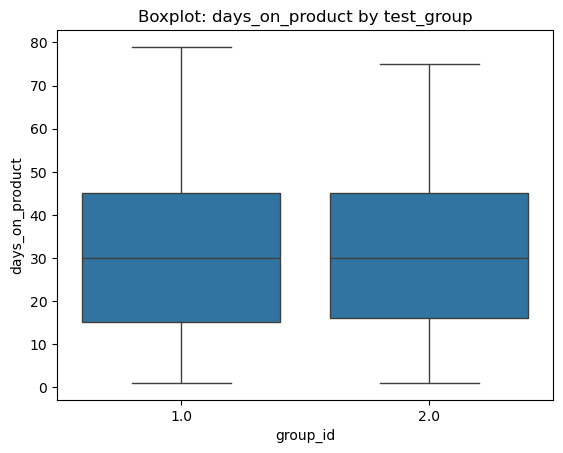

In [17]:
sns.boxplot(x="group_id", y="days_on_product", data=user_df)
plt.title("Boxplot: days_on_product by test_group")
plt.show()

In [18]:
Q1 = user_df["days_on_product"].quantile(0.25)
Q3 = user_df["days_on_product"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = user_df[(user_df["days_on_product"] < lower_bound) | (user_df["days_on_product"] > upper_bound)]
print(f"Кількість викідів: {len(outliers)}")

Кількість викідів: 0


Проаналізуємо кількість записів по кожній group_id

In [19]:
group_a = len(user_df[user_df["group_id"] == 1])
group_b = len(user_df[user_df["group_id"] == 2])
print(f"Кількість записів в групі а {group_a}")
print(f"Кількість записів в групі b {group_b}")

Кількість записів в групі а 4926
Кількість записів в групі b 5033


Оскільки кількість пропусків у колонці group_id невелика (41 запис), було прийнято рішення замінити їх на групу A (1), оскільки в цій групі трохи менше даних. Такий підхід мінімально впливає на баланс між групами та дозволяє зберегти цілісність аналізу A/B тесту.

In [20]:
user_df["group_id"] = user_df["group_id"].fillna(1)
group_a_n= len(user_df[user_df["group_id"] == 1])
print(f"Кількість записів в групі а {group_a_n}")
print(f"Кількість записів в групі b {group_b}")

Кількість записів в групі а 4967
Кількість записів в групі b 5033


Кількість пропусків у колонці device_id невелика (203 записи, приблизно 2% від усіх даних). Для збереження повноти вибірки та мінімізації впливу на розподіл користувачів було вирішено замінити пропущені значення на моду device_id у відповідній групі. Такий підхід дозволяє зберегти логіку розподілу пристроїв у групах і не спотворює результати подальшого A/B аналізу.

In [21]:
device_counts = user_df.groupby("group_id")["device_id"].value_counts()
device_counts

group_id  device_id
1.0       2.0          2894
          1.0          1431
          5.0           526
          3.0             7
          4.0             7
2.0       2.0          2911
          1.0          1519
          5.0           486
          4.0            10
          3.0             6
Name: count, dtype: int64

In [22]:
moda_a = user_df[user_df["group_id"] == 1]["device_id"].mode()[0]
moda_b = user_df[user_df["group_id"] == 2]["device_id"].mode()[0]

print(f"Мода група А {moda_a}.")
print(f"Мода група B {moda_b}.")

Мода група А 2.0.
Мода група B 2.0.


In [23]:
user_df.loc[(user_df["group_id"] == 1) & (user_df["device_id"].isnull()), "device_id"] = moda_a
user_df.loc[(user_df["group_id"] == 2) & (user_df["device_id"].isnull()), "device_id"] = moda_b

Колонка country_id містить 669 пропусків (приблизно 6–7% від усіх даних), що є значною часткою. Для збереження повноти вибірки та реалістичного розподілу країн було прийнято рішення заповнити пропущені значення випадковим чином у межах кожної групи, з ймовірністю пропорційною до наявного розподілу країн у групі. Такий підхід дозволяє зберегти статистичну коректність A/B тесту та уникнути спотворення сегментного аналізу.

In [24]:
country_counts = user_df.groupby("group_id")["country_id"].value_counts()
country_counts

group_id  country_id
1.0       5.0           967
          2.0           938
          4.0           933
          3.0           919
          1.0           873
          6.0            13
2.0       4.0           957
          5.0           955
          3.0           940
          2.0           917
          1.0           902
          6.0            17
Name: count, dtype: int64

In [25]:
for group in user_df["group_id"].unique():
    mask = (user_df["group_id"] == group) & (user_df["country_id"].isnull())
    probs = user_df[user_df["group_id"] == group]["country_id"].value_counts(normalize=True)
    user_df.loc[mask, "country_id"] = np.random.choice(
        probs.index, size=mask.sum(), p=probs.values
    )

Після виправлень ще раз перевіряємо пропущені дані

In [26]:
user_df.isnull().sum()

user_id              0
device_id            0
country_id           0
group_id             0
days_on_product    171
dtype: int64

Ще раз дивимось на типи даних

In [27]:
user_df.dtypes

user_id              int64
device_id          float64
country_id         float64
group_id           float64
days_on_product    float64
dtype: object

Замініємо усі колонки, крім **days_on_product** на тип даних **integer**, перевіряємо зміни

In [28]:
# знаходимо всі колонки, крім days_on_product
cols_to_int = user_df.columns.difference(["days_on_product"])

# приводимо їх до int
user_df[cols_to_int] = user_df[cols_to_int].astype(int)

user_df.dtypes

user_id              int64
device_id            int64
country_id           int64
group_id             int64
days_on_product    float64
dtype: object

Тепер подивимось на таблицю daily

In [29]:
daily_df.head()

,user_id,date,converted
0,2518,2025-08-04,0.0
1,1157,2025-08-16,0.0
2,1240,2025-08-11,0.0
3,9009,2025-08-20,0.0
4,8494,2025-08-08,0.0


In [30]:
num_records_daily = len(daily_df)
missing_values_daily = daily_df.isnull().sum()

print(f'Загальна кількість записів: {num_records_daily}')

print(f'Кількість пропущених записів:')
missing_values_daily

Загальна кількість записів: 61501
Кількість пропущених записів:


user_id        0
date           0
converted    516
dtype: int64

Для того щоб проаналізувати розподіл по групам стовпчика converted, створимо таблицю merged_df

In [31]:
merged_df = daily_df.merge(user_df[['user_id', 'group_id']], on='user_id', how='left')
merged_df

,user_id,date,converted,group_id
0,2518,2025-08-04,0.0,2
1,1157,2025-08-16,0.0,2
2,1240,2025-08-11,0.0,1
3,9009,2025-08-20,0.0,1
4,8494,2025-08-08,0.0,2
...,...,...,...,...
61496,2017,2025-08-15,0.0,1
61497,9493,2025-08-01,0.0,1
61498,2344,2025-08-12,0.0,2
61499,9310,2025-08-20,0.0,2


In [32]:
converted_counts = merged_df.groupby("group_id")["converted"].value_counts()
missing_counts_merge = merged_df[merged_df['converted'].isnull()]\
    .groupby('group_id')['converted'].size()

print(converted_counts)
print(missing_counts_merge)

group_id  converted
1         0.0          28078
          1.0           2310
2         0.0          27419
          1.0           3178
Name: count, dtype: int64
group_id
1    257
2    259
Name: converted, dtype: int64


In [33]:
merged_df.groupby("group_id")["converted"].describe()

,count,mean,std,min,25%,50%,75%,max
group_id,,,,,,,,
1,30388.0,0.076017,0.265029,0.0,0.0,0.0,0.0,1.0
2,30597.0,0.103866,0.305092,0.0,0.0,0.0,0.0,1.0


У процесі попередньої обробки даних було виявлено 516 пропущених значень у колонці converted. Для прийняття рішення щодо заповнення ми провели аналіз розподілу значень по групах користувачів group_id. Результати показали, що у кожній групі переважає значення converted = 0.0, медіана для обох груп дорівнює 0.0, частка пропущених значень становить менше 1% від загальної кількості записів.На основі цього було прийнято рішення заповнити всі пропущені значення медіаною по групі, тобто значенням 0.0

In [34]:
daily_df['converted'] = daily_df['converted'].fillna(0.0)
daily_df.isnull().sum()

user_id      0
date         0
converted    0
dtype: int64

In [35]:
daily_df.dtypes

user_id               int64
date         datetime64[ns]
converted           float64
dtype: object

In [36]:
daily_df['converted'] = daily_df['converted'].astype(int)
daily_df.dtypes

user_id               int64
date         datetime64[ns]
converted             int64
dtype: object

In [37]:
# Визначення періоду
start_date = '2025-08-01'
end_date = '2025-08-20'
# Фільтрація
daily_df = daily_df[(daily_df['date'] >= start_date) & (df['date'] <= end_date)]
daily_df

,user_id,date,converted
0,2518,2025-08-04,0
1,1157,2025-08-16,0
2,1240,2025-08-11,0
3,9009,2025-08-20,0
4,8494,2025-08-08,0
...,...,...,...
61496,2017,2025-08-15,0
61497,9493,2025-08-01,0
61498,2344,2025-08-12,0
61499,9310,2025-08-20,0


Дивимось на дублікати

In [38]:
duplicates = daily_df[daily_df.duplicated(subset=["user_id", "date"], keep=False)]
duplicates

,user_id,date,converted
40,740,2025-08-04,0
55,7606,2025-08-05,0
80,610,2025-08-01,0
97,6541,2025-08-13,0
126,6233,2025-08-14,0
...,...,...,...
61389,5714,2025-08-19,0
61418,1040,2025-08-09,0
61439,6160,2025-08-17,0
61451,6970,2025-08-12,0


Видаляємо дублікати

In [39]:
daily_df = daily_df.drop_duplicates(subset=["user_id", "date"], keep="first")

Дивимось на зміну кількості строк

In [40]:
len(daily_df)

60235

Оновлюємо сторінку

In [41]:
all_sheets["daily"] = daily_df

Крок 5: 
Зберігаємо у файл Excel

In [42]:
with pd.ExcelWriter('a_b_test_new.xlsx', engine='openpyxl') as writer:
    for sheet_name, df in all_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

Підгружаємо дані в PostgreSql

In [44]:
# 🔹 Параметри підключення
user = "postgres"
password = PASSWORD
host = "localhost"
port = "5432"
database = "ab_test_v16"

In [45]:
# 🔹 Створюємо SQLAlchemy engine
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

# 🔹 Шлях до Excel
excel_file = r"C:\Users\Дарья\Desktop\jupyter\a_b_test_new.xlsx"

# 🔹 Читаємо всі листи
sheets = pd.read_excel(excel_file, sheet_name=None)

In [43]:
# 🔹 Завантаження кожного листа в PostgreSQL
for sheet_name, df in sheets.items():
    print(f"Обробляю лист: {sheet_name}")

    # Очистка назв колонок (пробіли → "_")
    df.columns = [col.strip().replace(" ", "_") for col in df.columns]

    # Завантаження в PostgreSQL (replace якщо таблиця існує)
    df.to_sql(sheet_name, engine, if_exists='replace', index=False)

print("✅ Усі листи з Excel завантажено в PostgreSQL!")

Обробляю лист: device
Обробляю лист: country
Обробляю лист: group
Обробляю лист: user
Обробляю лист: daily
✅ Усі листи з Excel завантажено в PostgreSQL!


Підгружаємо з PostgreSql view для аналізу A/B-тесту

In [46]:
df = pd.read_sql("SELECT * FROM v_ab_test", engine)

In [47]:
df

,user_id,group_label,country_code,device_name,date,converted
0,2518,B,BR,Mobile,2025-08-04,0.0
1,1157,B,IN,Mobile,2025-08-16,0.0
2,1240,A,IN,Tablet,2025-08-11,0.0
3,9009,A,IN,Desktop,2025-08-20,0.0
4,8494,B,FR,Mobile,2025-08-08,0.0
...,...,...,...,...,...,...
60234,6343,B,IN,Mobile,2025-08-20,0.0
60235,1549,A,DE,Mobile,NaT,NaN
60236,7118,A,US,Mobile,NaT,NaN
60237,7485,B,BR,Mobile,NaT,NaN


In [48]:
df.isnull().sum()

user_id         0
group_label     0
country_code    0
device_name     0
date            4
converted       4
dtype: int64

In [49]:
converted_users_A = df[(df["group_label"] == "A") & (df["converted"] == 1)]["user_id"].nunique()
converted_users_A

1812

In [50]:
total_users_A = df[df["group_label"] == "A"]["user_id"].nunique()
total_users_A

4967

In [51]:
converted_users_B = df[(df["group_label"] == "B") & (df["converted"] == 1)]["user_id"].nunique()
converted_users_B

2313

In [52]:
total_users_B = df[df["group_label"] == "B"]["user_id"].nunique()
total_users_B

5033

In [53]:
# Розрахунок конверсії
conversion_rate_A = converted_users_A/ total_users_A
conversion_rate_B = converted_users_B/ total_users_B

print(f"Конверсія A: {conversion_rate_A * 100:.2f}%")
print(f"Конверсія B: {conversion_rate_B * 100:.2f}%")

Конверсія A: 36.48%
Конверсія B: 45.96%


In [71]:
# Розрахунок абсолютної та відносної різниці в конверсії між групами
abs_diff = conversion_rate_B - conversion_rate_A
rel_diff = (conversion_rate_B  - conversion_rate_A) / conversion_rate_A

print(f"Абсолютна різниця конверсії: {abs_diff * 100:.2F} p.p.")
print(f"Відносна різниця конверсії: {rel_diff * 100:.2F}%")

Абсолютна різниця конверсії: 9.48 p.p.
Відносна різниця конверсії: 25.98%


In [72]:
# Z-тест

# Обчислення зведеної конверсії (pooled)
p_pool = (converted_users_A + converted_users_B) / (total_users_A + total_users_B)

# Стандартна помилка
SE = (p_pool * (1 - p_pool) * (1/total_users_A + 1/total_users_B)) ** 0.5

# Z-статистика
Z = (conversion_rate_B - conversion_rate_A) / SE

# Двостороннє p-value
p_value = 2 * (1 - stats.norm.cdf(abs(Z)))
print(f"Z-статистика: {Z:.3f}")
print(f"p-value: {p_value:.4f}")

Z-статистика: 9.624
p-value: 0.0000


In [56]:
# Чи можно відхилити нульову гіпотезу?

alpha = 0.05
if p_value < alpha:
    print("Відхиляємо нульову гіпотезу: новий промоекран має статистично значущий ефект.")
else:
    print("Не можемо відхилити нульову гіпотезу: ефект не є статистично значущим.")

Відхиляємо нульову гіпотезу: новий промоекран має статистично значущий ефект.


In [57]:
grouped = df.groupby('group_label')['converted'].agg(['sum', 'count'])

In [73]:
ci_low, ci_upp = proportion_confint(
    count=grouped['sum'], 
    nobs=grouped['count'], 
    alpha=0.05, 
    method='wilson'
)

for i, label in enumerate(grouped.index):
    print(f"Група {label}: 95% CI = {ci_low[i]:.3f} – {ci_upp[i]:.3f}")

Група A: 95% CI = 0.072 – 0.078
Група B: 95% CI = 0.100 – 0.106


C:\Users\Дарья\AppData\Local\Temp\ipykernel_15568\2985493340.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Група {label}: 95% CI = {ci_low[i]:.3f} – {ci_upp[i]:.3f}")


In [59]:
# Формуємо таблицю
df_groups = pd.DataFrame({
    "group": ["A", "B"],
    "total_users": [total_users_A, total_users_B],
    "converted_users": [converted_users_A, converted_users_B],
    "conversion_rate": [round(conversion_rate_A, 3), round(conversion_rate_B, 3)],
    "ci_low": [round(ci_low[0], 3), round(ci_low[1], 3)],
    "ci_upp": [round(ci_upp[0], 3), round(ci_upp[1], 3)]
})


# ---- Збереження у PostgreSQL ----
df_groups.to_sql("ab_test_groups", con=engine, if_exists="replace", index=False)

C:\Users\Дарья\AppData\Local\Temp\ipykernel_15568\2630816674.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "ci_low": [round(ci_low[0], 3), round(ci_low[1], 3)],
C:\Users\Дарья\AppData\Local\Temp\ipykernel_15568\2630816674.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "ci_upp": [round(ci_upp[0], 3), round(ci_upp[1], 3)]


2

In [75]:
# Додаємо ще одну таблицю з загальними метриками
df_summary = pd.DataFrame([{
    "abs_diff": round(abs_diff, 3),
    "rel_diff": round(rel_diff, 4),   
    "z_score": round(Z, 3),
    "p_value": round(p_value, 4),
    "hypothesis_result": "Відхиляємо H0" if p_value < 0.05 else "Не відхиляємо H0"
}])

df_summary.to_sql("ab_test_summary", con=engine, if_exists="replace", index=False)

1

In [63]:
combined_results = []
alpha = 0.05

# Групування по країні та пристрою
for (country, device), sub_df in df.groupby(['country_code', 'device_name']):
    for group in ['A', 'B']:
        users = sub_df[sub_df["group_label"] == group]["user_id"].nunique()
        converted = sub_df[(sub_df["group_label"] == group) & (sub_df["converted"] == 1)]["user_id"].nunique()
        conversion = converted / users if users > 0 else 0

        combined_results.append({
            'group_label': group,
            'country_code': country,
            'device_name': device,
            'users': users,
            'converted': converted,
            'conversion_rate': round(conversion, 3)
        })
        
# Тепер робимо DataFrame
df_combined_long = pd.DataFrame(combined_results)

df_combined_long.to_sql("ab_test_device_country", con=engine, if_exists="replace", index=False)

56

In [68]:
aggregated_results = []

for (country, device), sub_df in df_combined_long.groupby(['country_code', 'device_name']):
    if set(sub_df['group_label']) == {'A','B'}:
        conv_A = sub_df.loc[sub_df['group_label']=='A', 'conversion_rate'].values[0]
        conv_B = sub_df.loc[sub_df['group_label']=='B', 'conversion_rate'].values[0]
        users_A = sub_df.loc[sub_df['group_label']=='A', 'users'].values[0]
        users_B = sub_df.loc[sub_df['group_label']=='B', 'users'].values[0]
        converted_A = sub_df.loc[sub_df['group_label']=='A', 'converted'].values[0]
        converted_B = sub_df.loc[sub_df['group_label']=='B', 'converted'].values[0]

    if users_A > 0 and users_B > 0:
        lift = (conv_B - conv_A) / conv_A * 100 if conv_A > 0 else None

        # z-test для пропорцій
        count = [converted_B, converted_A]
        nobs = [users_B, users_A]
        stat, p_value = proportions_ztest(count, nobs)

        # Висновок по H0
        if p_value < alpha:
            conclusion = "Відхиляємо H0 (ефект значущий)"
        else:
            conclusion = "Не відхиляємо H0 (ефект незначущий)"


        aggregated_results.append({
            'country': country,
            'device': device,
            'conversion_A': round(conv_A, 3),
            'conversion_B': round(conv_B, 3),
            'lift_%': round(lift, 2) if lift is not None else None,
            'p_value': round(p_value, 4) if p_value is not None else None,
            'hypothesis_result': conclusion
        })

df_combined = pd.DataFrame(aggregated_results)

E:\anaconda\envs\pydata-book\lib\site-packages\statsmodels\stats\weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


In [69]:
df_combined

,country,device,conversion_A,conversion_B,lift_%,p_value,hypothesis_result
0,BR,Desktop,0.206,0.360,74.76,0.0001,Відхиляємо H0 (ефект значущий)
1,BR,Mobile,0.334,0.421,26.05,0.0025,Відхиляємо H0 (ефект значущий)
2,BR,Smartwatch,0.000,0.000,NaN,NaN,Не відхиляємо H0 (ефект незначущий)
3,BR,TV,1.000,0.000,-100.00,0.1573,Не відхиляємо H0 (ефект незначущий)
4,BR,Tablet,0.380,0.354,-6.84,0.6972,Не відхиляємо H0 (ефект незначущий)
5,DE,Desktop,0.227,0.352,55.07,0.0008,Відхиляємо H0 (ефект значущий)
6,DE,Mobile,0.361,0.475,31.58,0.0001,Відхиляємо H0 (ефект значущий)
7,DE,Smartwatch,0.500,0.000,-100.00,0.3865,Не відхиляємо H0 (ефект незначущий)
8,DE,TV,0.000,0.800,NaN,0.0285,Відхиляємо H0 (ефект значущий)
9,DE,Tablet,0.259,0.449,73.36,0.0039,Відхиляємо H0 (ефект значущий)


In [70]:
df_combined.to_sql(
    name="ab_test_results",  
    con=engine,               
    if_exists="replace",     
    index=False               
)

28